In [2]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor

In [3]:
train_df = pd.read_csv('combined_train_with_labels.csv.gz')
test_df = pd.read_csv('combined_test_with_labels.csv.gz')

In [4]:
train_reg_df = train_df[(train_df["psd_label_low_avse"]==1) & (train_df["psd_label_high_avse"]==1) & (train_df["psd_label_dcr"]==1) & (train_df["psd_label_lq"]==1)]
test_reg_df = test_df[(test_df["psd_label_low_avse"]==1) & (test_df["psd_label_high_avse"]==1) & (test_df["psd_label_dcr"]==1) & (test_df["psd_label_lq"]==1)]

In [5]:
y_train = train_reg_df["energy_label"]
X_train = train_reg_df.drop(columns=["energy_label", "id","psd_label_low_avse","psd_label_high_avse","psd_label_dcr","psd_label_lq"])
y_test = test_reg_df["energy_label"]
X_test = test_reg_df.drop(columns=["energy_label", "id","psd_label_low_avse","psd_label_high_avse","psd_label_dcr","psd_label_lq"])
feature_cols = X_train.columns
X_test = X_test[feature_cols]



In [6]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LinearRegression())
])

pipe.fit(X_train, y_train)


,steps,"[('scaler', ...), ('lr', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None


In [7]:
y_train_pred = pipe.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)

# Test metrics (you already have these)
y_test_pred = pipe.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)

print("Train RMSE:", rmse_train, " | Train R2:", r2_train)
print("Test  RMSE:", rmse_test,  " | Test  R2:", r2_test)

Train RMSE: 61.962453553947356  | Train R2: 0.989254903261862
Test  RMSE: 59.45033242042509  | Test  R2: 0.9899879075088875


In [8]:
y_pred = pipe.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("MAE :", mae)
print("R²  :", r2)


RMSE: 59.45033242042509
MAE : 23.040580553972323
R²  : 0.9899879075088875


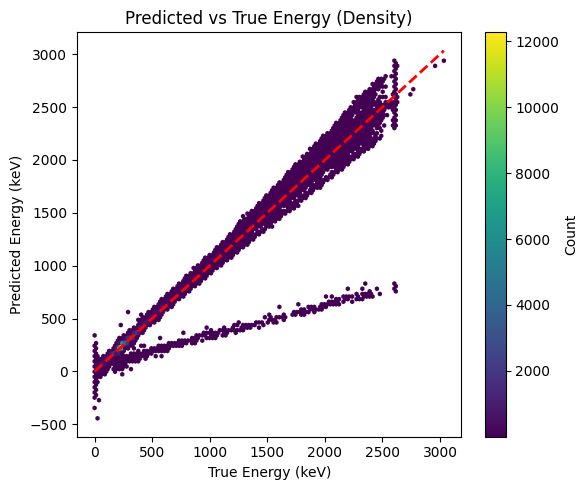

In [9]:
plt.figure(figsize=(6,5))
plt.hexbin(y_test, y_pred, gridsize=120, mincnt=1)
mn, mx = float(y_test.min()), float(y_test.max())
plt.plot([mn, mx], [mn, mx], "r--", linewidth=2)
plt.xlabel("True Energy (keV)")
plt.ylabel("Predicted Energy (keV)")
plt.title("Predicted vs True Energy (Density)")
plt.colorbar(label="Count")
plt.tight_layout()
plt.show()

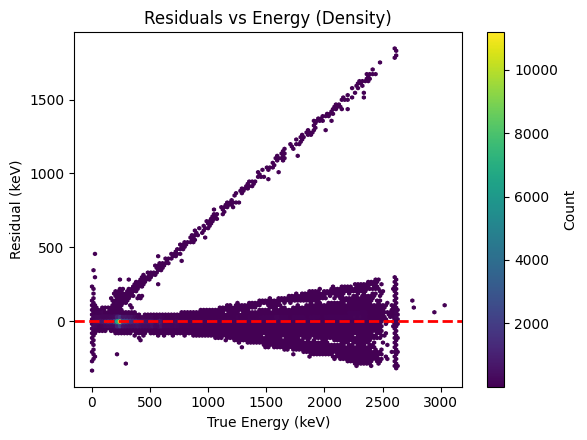

In [10]:
residuals = y_test - y_pred

plt.figure(figsize=(6,4.5))
plt.hexbin(y_test, residuals, gridsize=120, mincnt=1)
plt.axhline(0, color="r", linestyle="--", linewidth=2)
plt.xlabel("True Energy (keV)")
plt.ylabel("Residual (keV)")
plt.title("Residuals vs Energy (Density)")
plt.colorbar(label="Count")
plt.tight_layout()
plt.show()


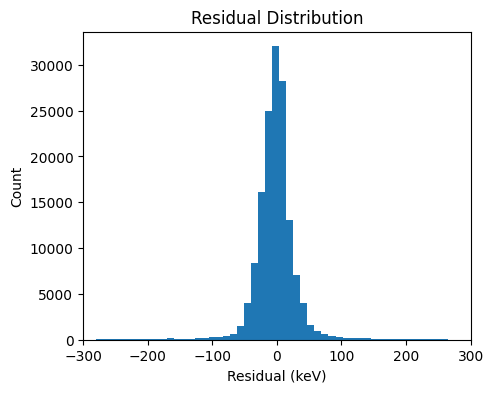

In [11]:
plt.figure(figsize=(5,4))
plt.hist(residuals, bins=200)
plt.xlabel("Residual (keV)")
plt.ylabel("Count")
plt.title("Residual Distribution")
plt.xlim(-300, 300) 
plt.show()


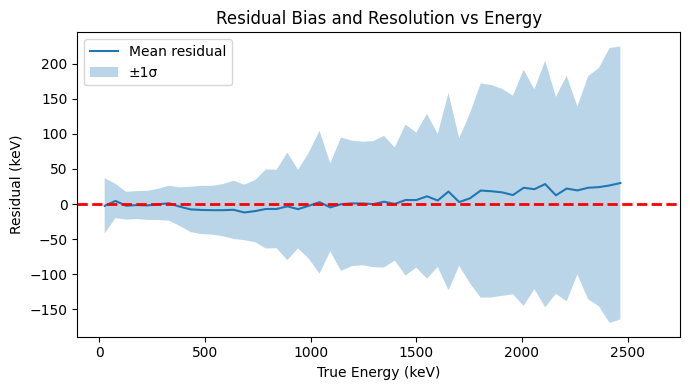

In [12]:
bins = np.linspace(0, 3000, 60)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

mean_res, std_res = [], []

for lo, hi in zip(bins[:-1], bins[1:]):
    mask = (y_test >= lo) & (y_test < hi)
    if mask.sum() > 50:  # avoid noisy bins
        r = residuals[mask]
        mean_res.append(r.mean())
        std_res.append(r.std())
    else:
        mean_res.append(np.nan)
        std_res.append(np.nan)

mean_res = np.array(mean_res)
std_res  = np.array(std_res)

plt.figure(figsize=(7,4))
plt.plot(bin_centers, mean_res, label="Mean residual", color="C0")
plt.fill_between(
    bin_centers,
    mean_res - std_res,
    mean_res + std_res,
    alpha=0.3,
    label="±1σ"
)
plt.axhline(0, color="red", linestyle="--", linewidth=2)

plt.xlabel("True Energy (keV)")
plt.ylabel("Residual (keV)")
plt.title("Residual Bias and Resolution vs Energy")
plt.legend()
plt.tight_layout()
plt.show()

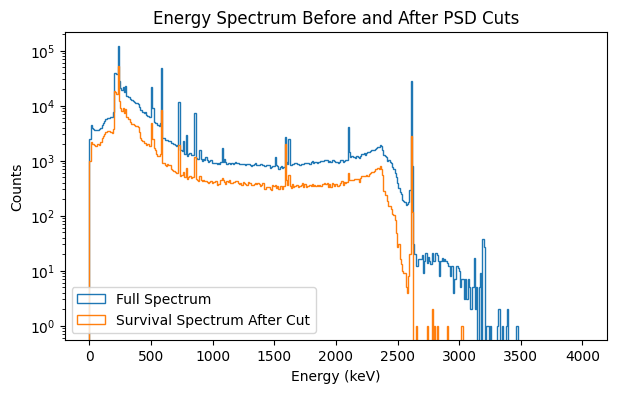

In [13]:
bins = np.linspace(0, 4000, 400)

plt.figure(figsize=(7,4))
plt.hist(train_df["energy_label"], bins=bins,
         histtype="step", label="Full Spectrum", log=True)

plt.hist(train_reg_df["energy_label"], bins=bins,
         histtype="step", label="Survival Spectrum After Cut", log=True)

plt.xlabel("Energy (keV)")
plt.ylabel("Counts")
plt.legend()
plt.title("Energy Spectrum Before and After PSD Cuts")
plt.show()


In [14]:
res = y_test - y_pred
print("Pct |residual| > 200 keV:", (res.abs() > 200).mean())
print("Pct |residual| > 500 keV:", (res.abs() > 500).mean())


Pct |residual| > 200 keV: 0.008182069598181463
Pct |residual| > 500 keV: 0.0016323667293981154


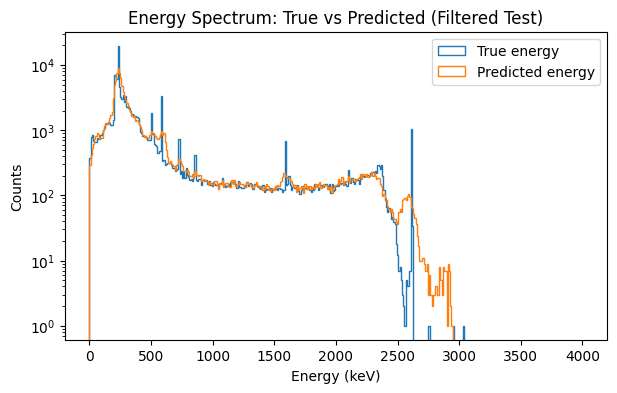

In [15]:
import numpy as np
import matplotlib.pyplot as plt

bins = np.linspace(0, 4000, 400)

plt.figure(figsize=(7,4))
plt.hist(y_test, bins=bins, histtype="step", log=True, label="True energy")
plt.hist(y_pred, bins=bins, histtype="step", log=True, label="Predicted energy")
plt.xlabel("Energy (keV)")
plt.ylabel("Counts")
plt.legend()
plt.title("Energy Spectrum: True vs Predicted (Filtered Test)")
plt.show()


In [16]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)
lgbm = LGBMRegressor(n_estimators=5000,learning_rate=0.03,num_leaves=63,subsample=0.8,colsample_bytree=0.8,reg_alpha=0.0,reg_lambda=1.0,random_state=42,n_jobs=-1)

lgbm.fit(X_tr, y_tr,eval_set=[(X_val, y_val)],eval_metric="rmse",callbacks=[],)

# LightGBM sklearn API supports early stopping via callbacks:
from lightgbm import early_stopping
lgbm.fit( X_tr, y_tr,eval_set=[(X_val, y_val)],eval_metric="rmse",callbacks=[early_stopping(stopping_rounds=200, verbose=False)])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5267
[LightGBM] [Info] Number of data points in the train set: 336029, number of used features: 23
[LightGBM] [Info] Start training from score 550.511642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5267
[LightGBM] [Info] Number of data points in the train set: 336029, number of used features: 23
[LightGBM] [Info] Start training from score 550.511642


,boosting_type,'gbdt'
,num_leaves,63
,max_depth,-1
,learning_rate,0.03
,n_estimators,5000
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [17]:
def eval_reg(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f"{name} RMSE: {rmse:.3f} | MAE: {mae:.3f} | R2: {r2:.6f}")
    return rmse, mae, r2

y_tr_pred   = lgbm.predict(X_train)
y_test_pred = lgbm.predict(X_test)

eval_reg(y_train, y_tr_pred, "Train")
eval_reg(y_test,  y_test_pred, "Test")

res = y_test - y_test_pred
print("Pct |res| > 200 keV:", (np.abs(res) > 200).mean())
print("Pct |res| > 500 keV:", (np.abs(res) > 500).mean())


Train RMSE: 10.306 | MAE: 3.160 | R2: 0.999703
Test RMSE: 21.044 | MAE: 4.442 | R2: 0.998745
Pct |res| > 200 keV: 0.0012478836567712866
Pct |res| > 500 keV: 0.00031702990199054305


In [18]:
import pandas as pd

imp = pd.Series(lgbm.feature_importances_, index=feature_cols).sort_values(ascending=False)
print(imp.head(20))


tail_slope_no_pz           32359
total_power                25373
LQ80                       23920
gbn                        21078
tail_slope                 20350
bpr                        16362
current_width              16095
spectral_centroid_power    14975
HWP                        13857
SCA                        13840
current_skewness           13799
PPR                        13482
tdrift10                   12992
tp0                        12601
current_kurtosis           11964
tfr                        10489
time_to_main_peak           8775
tdrift50                    8175
ED                          6830
tdrift99                    6471
dtype: int32


In [19]:
y_pred_lr   = pipe.predict(X_test)
y_pred_lgbm = lgbm.predict(X_test)

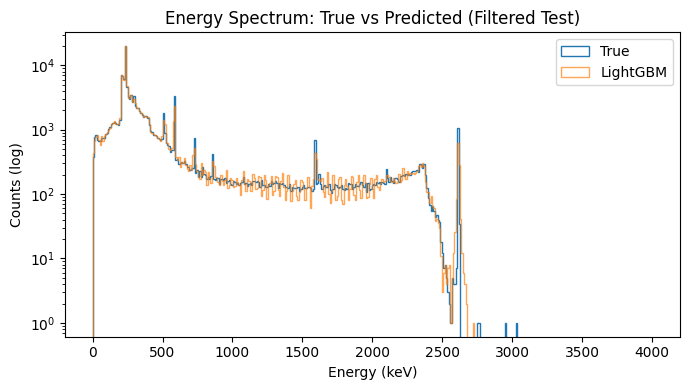

In [21]:
bins = np.linspace(0, 4000, 400)

plt.figure(figsize=(7,4))
plt.hist(y_test, bins=bins, histtype="step", log=True, label="True")
# plt.hist(y_pred_lr, bins=bins, histtype="step", log=True, label="LinearReg")
plt.hist(y_pred_lgbm, bins=bins, histtype="step", log=True, label="LightGBM", alpha=0.7)
plt.xlabel("Energy (keV)")
plt.ylabel("Counts (log)")
plt.title("Energy Spectrum: True vs Predicted (Filtered Test)")
plt.legend()
plt.tight_layout()
plt.show()


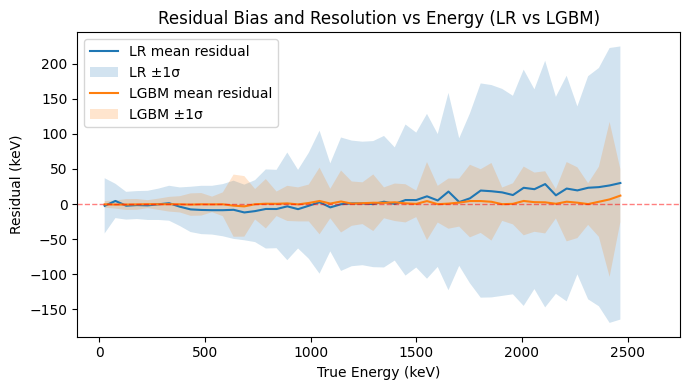

In [111]:
def binned_bias_sigma(y_true, y_pred, bins, min_n=50):
    res = y_true - y_pred
    centers = 0.5*(bins[1:]+bins[:-1])
    mean_res, std_res = [], []
    for lo, hi in zip(bins[:-1], bins[1:]):
        m = (y_true >= lo) & (y_true < hi)
        if m.sum() >= min_n:
            r = res[m]
            mean_res.append(r.mean())
            std_res.append(r.std())
        else:
            mean_res.append(np.nan); std_res.append(np.nan)
    return centers, np.array(mean_res), np.array(std_res)

bins_e = np.linspace(0, 3000, 60)

c, m_lr, s_lr = binned_bias_sigma(y_test, y_pred_lr,   bins_e)
_, m_gb, s_gb = binned_bias_sigma(y_test, y_pred_lgbm, bins_e)

plt.figure(figsize=(7,4))
plt.plot(c, m_lr, label="LR mean residual")
plt.fill_between(c, m_lr-s_lr, m_lr+s_lr, alpha=0.2, label="LR ±1σ")
plt.plot(c, m_gb, label="LGBM mean residual")
plt.fill_between(c, m_gb-s_gb, m_gb+s_gb, alpha=0.2, label="LGBM ±1σ")
plt.axhline(0, color="red", linestyle="--", alpha = 0.5, linewidth = 1)
plt.xlabel("True Energy (keV)")
plt.ylabel("Residual (keV)")
plt.title("Residual Bias and Resolution vs Energy (LR vs LGBM)")
plt.legend()
plt.tight_layout()
plt.show()

In [87]:
import shap

# sample to keep it fast (adjust n if you want)
n_bg  = 2000   # background for explainer
n_exp = 5000   # points to explain

X_bg  = X_train.sample(n=n_bg, random_state=42)
X_exp = X_test.sample(n=n_exp, random_state=42)

explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_exp)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


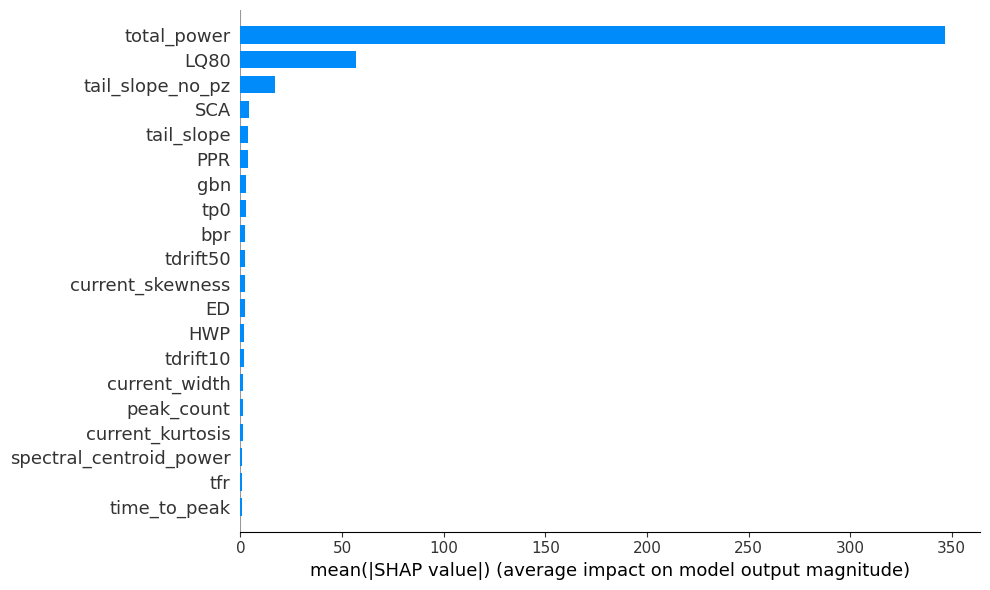

In [93]:
shap.summary_plot(shap_values, X_exp, plot_type="bar", max_display=20, plot_size=[10, 6])


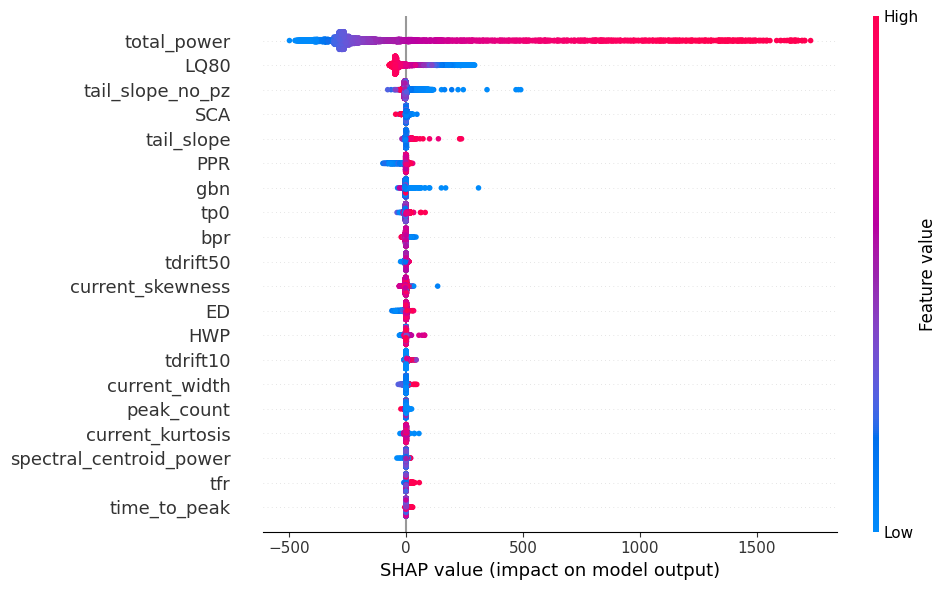

In [94]:
shap.summary_plot(shap_values, X_exp, max_display=20, plot_size=[10, 6])


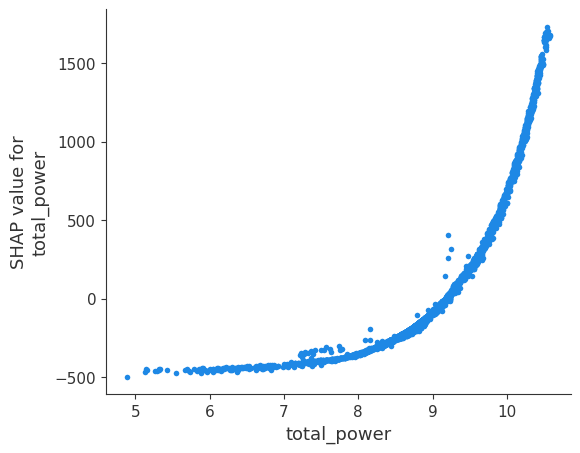

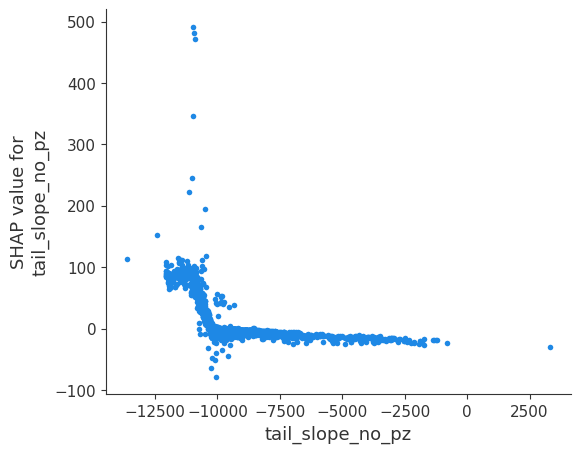

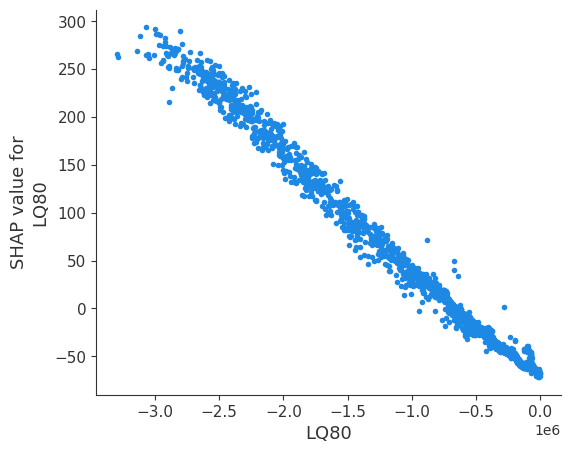

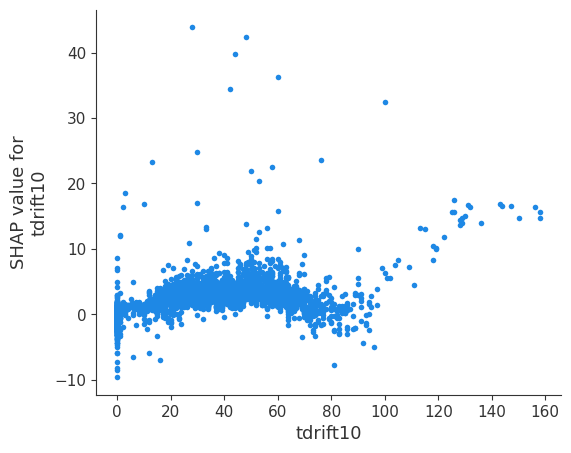

In [105]:
for feat in ["total_power", "tail_slope_no_pz", "LQ80", "tdrift10"]:
    if feat in X_exp.columns:
        shap.dependence_plot(feat, shap_values, X_exp,interaction_index=None)
